In [57]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import torch


In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = "SPY.csv"
df = pd.read_csv(file_path)




# start to nov 2001 (dot com crash)
# not bad
# df = df.iloc[:2228]

# nov 01 to june 2009
# not bad
# df = df.iloc[2228:4135]

# june 2009 to april 2020
# ass
df = df.iloc[4135:6862]

# april 2020 to most recent
# ass
# df = df.iloc[6862:]


# Convert the "Date" column to datetime
# df["Date"] = pd.to_datetime(df["Date"], format='%Y/%m/%d')

# # Sort the data by date in ascending order
# df = df.sort_values(by="Date")

# # Get the earliest and latest dates
# earliest_date = df["Date"].min()
# latest_date = df["Date"].max()

# print("Earliest Date:", earliest_date)
# print("Latest Date:", latest_date)


In [60]:
print(df.tail())

            Date        Open        High         Low       Close     Volume  \
6857  2020-04-23  262.458644  265.686871  260.830509  261.139282  104709700   
6858  2020-04-24  262.683183  265.462257  260.596529  264.779175   85063200   
6859  2020-04-27  266.791031  269.738528  266.323174  268.596954   77896600   
6860  2020-04-28  272.311790  272.667366  267.053075  267.361877  105270000   
6861  2020-04-29  272.788998  275.923649  271.741002  274.360992  118745600   

      Day  Weekday  Week  Month  Year  
6857   23        3    17      4  2020  
6858   24        4    17      4  2020  
6859   27        0    18      4  2020  
6860   28        1    18      4  2020  
6861   29        2    18      4  2020  


In [61]:
# if 'Day' and 'Weekday' and 'Week' and 'Month' and 'Year' in df.columns:
    # df.drop(columns=['Day', 'Weekday', 'Week', 'Month', 'Year'], inplace=True)

In [62]:
if "Target" not in df.columns:
    # df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
    df["Target"] = df["Close"].shift(-1)


In [63]:
df = df.dropna()

In [64]:
# Adding SMA as part of the feature test
short_term_period = 20
medium_term_period = 50
long_term_period = 200

# Compute the SMAs
df['SMA_20'] = df['Close'].rolling(window=short_term_period).mean()
df['SMA_50'] = df['Close'].rolling(window=medium_term_period).mean()
df['SMA_200'] = df['Close'].rolling(window=long_term_period).mean()

df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()  # Short-term EMA
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()  # Medium-term EMA
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()  # Long-term EMA


In [65]:
df = df.dropna()

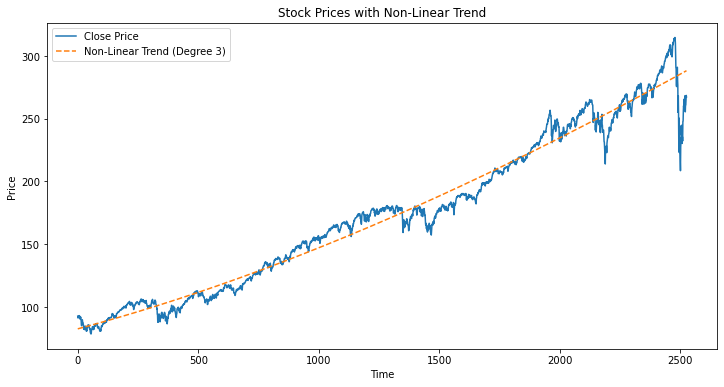

In [66]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Assuming you have a DataFrame `df` with a 'Close' column

# Create an index for the time series (usually the row number)
df['Time'] = np.arange(len(df))

# Fit a polynomial regression to the 'Close' price
X = df[['Time']]  # Independent variable (time)
y = df['Close']   # Dependent variable (closing price)

# Initialize a polynomial features transformer (degree = 2 for quadratic, or higher for more non-linearity)
degree = 3  # You can change the degree for more complexity
poly = PolynomialFeatures(degree)

# Transform the Time feature into polynomial features
X_poly = poly.fit_transform(X)

# Initialize and fit the linear regression model to the polynomial features
model = LinearRegression()
model.fit(X_poly, y)

# Generate predictions for the polynomial regression (non-linear trend)
df['Non_Linear_Trend'] = model.predict(X_poly)

# Optionally, visualize the non-linear trend
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['Close'], label='Close Price')
plt.plot(df['Time'], df['Non_Linear_Trend'], label=f'Non-Linear Trend (Degree {degree})', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Prices with Non-Linear Trend')
plt.legend()
plt.show()

## CREATING THE NEURAL NETWORK MODEL

In [67]:
dates = df["Date"]
X = df.drop(columns=["Date", "Target"])
y = df["Target"]

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


In [69]:
# Define the LSTM-based model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)  # Output layer for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)
        out = self.fc(out)  # Shape: (batch_size, 1)
        out = self.sigmoid(out)
        return out

# Define a more complex LSTM-based model
# class ComplexLSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
#         super(ComplexLSTMModel, self).__init__()
#         # LSTM Layer: Bidirectional for richer context
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
#                             batch_first=True, dropout=dropout_rate,
#                             bidirectional=True)
#         # Fully connected layers for added complexity
#         self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # Bidirectional LSTM doubles hidden size
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc3 = nn.Linear(hidden_size // 2, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         # LSTM expects input of shape (batch_size, sequence_length, input_size)
#         out, _ = self.lstm(x)
#         # Use the output of the last time step
#         out = out[:, -1, :]  # Shape: (batch_size, hidden_size * 2)
#         out = self.fc1(out)  # First fully connected layer
#         out = self.dropout1(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc2(out)  # Second fully connected layer
#         out = self.dropout2(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc3(out)  # Output layer
#         out = self.sigmoid(out)  # Apply sigmoid for binary classification
#         return out

# class ComplexLSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
#         super(ComplexLSTMModel, self).__init__()
#         # LSTM Layer: Bidirectional for richer context
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
#                             batch_first=True, dropout=dropout_rate,
#                             bidirectional=True)
#         # Fully connected layers for added complexity
#         self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # Bidirectional LSTM doubles hidden size
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc3 = nn.Linear(hidden_size // 2, 1)

#     def forward(self, x):
#         # LSTM expects input of shape (batch_size, sequence_length, input_size)
#         out, _ = self.lstm(x)
#         # Use the output of the last time step
#         out = out[:, -1, :]  # Shape: (batch_size, hidden_size * 2)
#         out = self.fc1(out)  # First fully connected layer
#         out = self.dropout1(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc2(out)  # Second fully connected layer
#         out = self.dropout2(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc3(out)  # Output layer
#         return out

class ComplexLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(ComplexLSTMModel, self).__init__()
        # Unidirectional LSTM for sequential stock price prediction
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate)  # Removed bidirectional=True

        # Fully connected layers for added complexity
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size // 4, 1)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        out = torch.relu(self.fc1(out))  # First fully connected layer
        out = self.dropout1(out)
        out = torch.relu(self.fc2(out))  # Second fully connected layer
        out = self.dropout2(out)
        out = self.fc3(out)  # Output layer (no activation for regression)
        return out


In [70]:

sequence_length = 10

# Reshape data into sequences
def create_sequences(data, target, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)


In [71]:

# scaler = StandardScaler()
# scaler = MinMaxScaler()
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Day", "Weekday", "Week", "Month", "Year"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200", "Non_Linear_Trend"]
feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Non_Linear_Trend", "SMA_20", "SMA_50", "EMA_10", "EMA_50"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Non_Linear_Trend"]

# Split data
train_size = int(X.shape[0] * 0.7)
val_size = int(X.shape[0] * 0.15)

# Initialize scaler
# scaler = RobustScaler()
scaler = MinMaxScaler()

# Split data into train, validation, and test
temp_train = X[:train_size]
temp_val = X[train_size:train_size + val_size]
temp_test = X[train_size + val_size:]

temp_train = temp_train[feature_columns]
temp_val = temp_val[feature_columns]
temp_test = temp_test[feature_columns]

# Fit and transform for train, transform for validation and test
temp_train = scaler.fit_transform(temp_train)
temp_val = scaler.transform(temp_val)
temp_test = scaler.transform(temp_test)

# Convert NumPy arrays back to DataFrames
temp_train = pd.DataFrame(temp_train, columns=feature_columns)
temp_val = pd.DataFrame(temp_val, columns=feature_columns)
temp_test = pd.DataFrame(temp_test, columns=feature_columns)

# Concatenate the data
X_scaled = pd.concat([temp_train, temp_val, temp_test], axis=0)

# scaler = StandardScaler()

# scaler.fit(X_train)
# X_scaled = pd.DataFrame(scaler.fit_transform(X[feature_columns]), columns=feature_columns, index=X.index)

X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)


# Split sequentially
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]

# Print sizes to confirm
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 1768, Val: 379, Test: 370


In [72]:

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 128
num_layers = 2
dropout_rate = 0.1
learning_rate = 0.0005
num_epochs = 500
patience = 30


# Initialize the LSTM model
# model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)
model = ComplexLSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)

model.to(device)

# Define loss and optimizer
# criterion = nn.BCELoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with early stopping
best_val_loss = float('inf')
early_stop_counter = 0

# if not os.path.exists("./models/best_lstm_model.pth"):
if not os.path.exists("./lstm_trials/lstm_after_gridsearch_new.pth"):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.unsqueeze(1)  # Match output shape
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_batch = y_batch.unsqueeze(1)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # torch.save(model.state_dict(), "./lstm_trials/lstm_after_gridsearch_new.pth")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"Early stopping counter: {early_stop_counter}/{patience}")
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

# Load the best model
# model.load_state_dict(torch.load("./lstm_trials/lstm_after_gridsearch_new.pth"))

# Evaluate on test data
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

# Calculate Mean Absolute Error (MAE)
test_mae = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        mae = torch.mean(torch.abs(outputs - y_batch))
        test_mae += mae.item() * X_batch.size(0)

test_mae /= len(test_loader.dataset)
print(f'Test MAE: {test_mae:.4f}')


Epoch 1/500, Train Loss: 21219.6364, Val Loss: 56121.2760
Epoch 2/500, Train Loss: 20384.2797, Val Loss: 53721.2272
Epoch 3/500, Train Loss: 18448.6565, Val Loss: 49309.8867
Epoch 4/500, Train Loss: 15400.8520, Val Loss: 42892.2578
Epoch 5/500, Train Loss: 11573.5269, Val Loss: 34627.3662
Epoch 6/500, Train Loss: 7230.6686, Val Loss: 25037.8092
Epoch 7/500, Train Loss: 3515.5609, Val Loss: 15121.7088
Epoch 8/500, Train Loss: 1711.1161, Val Loss: 8935.0946
Epoch 9/500, Train Loss: 1575.3086, Val Loss: 10284.2093
Early stopping counter: 1/30
Epoch 10/500, Train Loss: 1264.2527, Val Loss: 7677.0830
Epoch 11/500, Train Loss: 425.5255, Val Loss: 2902.8018
Epoch 12/500, Train Loss: 260.9163, Val Loss: 1511.7137
Epoch 13/500, Train Loss: 267.5463, Val Loss: 1529.5781
Early stopping counter: 1/30
Epoch 14/500, Train Loss: 271.0319, Val Loss: 1263.5060
Epoch 15/500, Train Loss: 259.5032, Val Loss: 1037.5026
Epoch 16/500, Train Loss: 256.8813, Val Loss: 927.2999
Epoch 17/500, Train Loss: 258.423

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [74]:
# X_seq_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
# y_seq_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# outputs = model(X_seq_tensor)

# error = 0
# largest_error = 0
# less_than_actual = 0
# more_than_actual = 0

# for true, pred in zip(y_test, outputs):
#     percent = abs(true - pred) / true
#     if percent > largest_error:
#         largest_error = percent
#     error += percent
#     if pred < true:
#         less_than_actual += 1
#     else:
#         more_than_actual += 1

# error = error / len(y_test)
# error = error.item()
# largest_error = largest_error.item()
# print(f"Average error percentage: {error*100}")
# print(f"Largest error percentage: {largest_error*100}")
# print(f"Less than actual: {less_than_actual}")
# print(f"More than actual: {more_than_actual}")



In [75]:

# plt.figure(figsize=(12, 6))
# plt.plot(y_test, label='True Values')
# plt.plot(outputs.cpu().detach().numpy(), label='Predicted Values')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('True vs Predicted Values')
# plt.legend()
# plt.show()

## Evaluating on entire dataset

In [76]:
# X_seq_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)
# y_seq_tensor = torch.tensor(y_seq, dtype=torch.float32).to(device)

# outputs = model(X_seq_tensor)


In [77]:
# error = 0
# largest_error = 0
# less_than_actual = 0
# more_than_actual = 0

# for true, pred in zip(y_seq, outputs):
#     percent = abs(true - pred) / true
#     if percent > largest_error:
#         largest_error = percent
#     error += percent
#     if pred < true:
#         less_than_actual += 1
#     else:
#         more_than_actual += 1

# error = error / len(y_seq)
# error = error.item()
# largest_error = largest_error.item()
# print(f"Average error percentage: {error*100}")
# print(f"Largest error percentage: {largest_error*100}")
# print(f"Less than actual: {less_than_actual}")
# print(f"More than actual: {more_than_actual}")


In [78]:
# train_cutoff = int(len(y_seq) * 0.7)
# val_cutoff = int(len(y_seq) * 0.85)

# plt.figure(figsize=(12, 6))
# plt.plot(y_seq, label='True Values')
# plt.plot(outputs.cpu().detach().numpy(), label='Predicted Values')
# plt.axvline(x=train_cutoff, color='g', linestyle='--', label='Train/Val Split (80%)')
# plt.axvline(x=val_cutoff, color='b', linestyle='--', label='Val/Test Split (90%)')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('True vs Predicted Values')
# plt.legend()
# plt.show()

In [79]:
# outputs

In [80]:
# df['Target_Higher_Lower'] = np.where(df['Target'] > df['Open'], 'higher', 'lower')

In [81]:
# # Ensure outputs is detached from the computation graph and converted to numpy
# predicted_values = outputs.cpu().detach().numpy()

# # Add the predicted values as a new column in the dataframe
# df['Predicted'] = np.nan
# df.loc[df.index[-len(predicted_values):], 'Predicted'] = predicted_values

# print(df[['Date', 'Target', 'Predicted']].tail())

In [82]:
new_df = df.dropna()

In [83]:
# new_df['Predicted_Higher_Lower'] = np.where(new_df['Predicted'] > new_df['Open'], 'higher', 'lower')
# new_df['Correct'] = np.where(new_df['Predicted_Higher_Lower'] == new_df['Target_Higher_Lower'], 1, 0)

# print('number of correct predictions:', new_df['Correct'].sum())


===== Trial 1 =====
Epoch 1/500, Train Loss: 21259.4009, Val Loss: 55863.6263
Epoch 2/500, Train Loss: 20109.4343, Val Loss: 52924.1250
Epoch 3/500, Train Loss: 17913.3802, Val Loss: 48254.9714
Epoch 4/500, Train Loss: 14806.7277, Val Loss: 41877.5378
Epoch 5/500, Train Loss: 11012.6018, Val Loss: 33704.6940
Epoch 6/500, Train Loss: 6900.1672, Val Loss: 24355.8070
Epoch 7/500, Train Loss: 3395.4636, Val Loss: 14897.7035
Epoch 8/500, Train Loss: 1735.3263, Val Loss: 8841.7766
Epoch 9/500, Train Loss: 1652.9782, Val Loss: 9853.9174
Epoch 10/500, Train Loss: 1592.7933, Val Loss: 9752.2377
Epoch 11/500, Train Loss: 926.7031, Val Loss: 5789.2269
Epoch 12/500, Train Loss: 346.2798, Val Loss: 2722.9729
Epoch 13/500, Train Loss: 328.1369, Val Loss: 2305.3297
Epoch 14/500, Train Loss: 282.2517, Val Loss: 1958.8241
Epoch 15/500, Train Loss: 289.1529, Val Loss: 1482.3315
Epoch 16/500, Train Loss: 287.5470, Val Loss: 1194.8900
Epoch 17/500, Train Loss: 263.4673, Val Loss: 1034.8244
Epoch 18/500, 

C:\Users\ROG\AppData\Local\Temp/ipykernel_8440/3105510446.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Epoch 1/500, Train Loss: 21164.4130, Val Loss: 55325.9408
Epoch 2/500, Train Loss: 19338.6659, Val Loss: 50620.7884
Epoch 3/500, Train Loss: 15925.0352, Val Loss: 43328.5788
Epoch 4/500, Train Loss: 11487.1088, Val Loss: 33773.9971
Epoch 5/500, Train Loss: 6579.1448, Val Loss: 22531.5028
Epoch 6/500, Train Loss: 2725.3670, Val Loss: 11568.0083
Epoch 7/500, Train Loss: 1551.3349, Val Loss: 9737.4167
Epoch 8/500, Train Loss: 1580.3702, Val Loss: 9799.5280
Epoch 9/500, Train Loss: 1390.0624, Val Loss: 8633.6384
Epoch 10/500, Train Loss: 439.9524, Val Loss: 2610.5453
Epoch 11/500, Train Loss: 248.1889, Val Loss: 2013.2852
Epoch 12/500, Train Loss: 229.5234, Val Loss: 1623.6571
Epoch 13/500, Train Loss: 224.9330, Val Loss: 1430.1195
Epoch 14/500, Train Loss: 218.2729, Val Loss: 1182.9501
Epoch 15/500, Train Loss: 190.4656, Val Loss: 1013.9186
Epoch 16/500, Train Loss: 195.6875, Val Loss: 925.9503
Epoch 17/500, Train Loss: 224.8964, Val Loss: 989.1054
Epoch 18/500, Train Loss: 222.4828, Val 

C:\Users\ROG\AppData\Local\Temp/ipykernel_8440/3105510446.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))
d:\Anaconda

Epoch 1/500, Train Loss: 21255.8501, Val Loss: 55978.3014
Epoch 2/500, Train Loss: 20082.7235, Val Loss: 52800.4915
Epoch 3/500, Train Loss: 17559.6129, Val Loss: 47134.5684
Epoch 4/500, Train Loss: 13808.9058, Val Loss: 39150.7767
Epoch 5/500, Train Loss: 9281.3041, Val Loss: 29312.3493
Epoch 6/500, Train Loss: 4908.1843, Val Loss: 18592.4061
Epoch 7/500, Train Loss: 2053.3756, Val Loss: 9037.4354
Epoch 8/500, Train Loss: 1623.3092, Val Loss: 10275.8923
Epoch 9/500, Train Loss: 1434.2771, Val Loss: 8998.5631
Epoch 10/500, Train Loss: 605.1118, Val Loss: 3637.2799
Epoch 11/500, Train Loss: 264.1065, Val Loss: 2010.3414
Epoch 12/500, Train Loss: 243.5647, Val Loss: 1315.3549
Epoch 13/500, Train Loss: 255.8604, Val Loss: 1165.2384
Epoch 14/500, Train Loss: 253.1915, Val Loss: 1140.5221
Epoch 15/500, Train Loss: 236.0071, Val Loss: 965.1577
Epoch 16/500, Train Loss: 224.4437, Val Loss: 1176.2090
Epoch 17/500, Train Loss: 227.9609, Val Loss: 910.8679
Epoch 18/500, Train Loss: 208.8146, Val

C:\Users\ROG\AppData\Local\Temp/ipykernel_8440/3105510446.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))
d:\Anaconda

Epoch 1/500, Train Loss: 21292.3922, Val Loss: 55987.5449
Epoch 2/500, Train Loss: 20159.6831, Val Loss: 53016.4349
Epoch 3/500, Train Loss: 17816.0437, Val Loss: 47810.2734
Epoch 4/500, Train Loss: 14330.3500, Val Loss: 40292.1439
Epoch 5/500, Train Loss: 9965.1269, Val Loss: 31046.1468
Epoch 6/500, Train Loss: 5733.1307, Val Loss: 20920.6800
Epoch 7/500, Train Loss: 2516.8104, Val Loss: 11164.7343
Epoch 8/500, Train Loss: 1567.1894, Val Loss: 9937.0579
Epoch 9/500, Train Loss: 1514.1586, Val Loss: 9238.6321
Epoch 10/500, Train Loss: 547.4618, Val Loss: 3853.7206
Epoch 11/500, Train Loss: 301.5517, Val Loss: 2220.3117
Epoch 12/500, Train Loss: 261.6313, Val Loss: 1500.6203
Epoch 13/500, Train Loss: 248.5780, Val Loss: 1392.3052
Epoch 14/500, Train Loss: 250.4290, Val Loss: 1338.2035
Epoch 15/500, Train Loss: 244.0558, Val Loss: 1180.5989
Epoch 16/500, Train Loss: 251.5272, Val Loss: 1356.5429
Epoch 17/500, Train Loss: 220.7096, Val Loss: 1081.5870
Epoch 18/500, Train Loss: 234.3410, V

C:\Users\ROG\AppData\Local\Temp/ipykernel_8440/3105510446.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))
d:\Anaconda

Epoch 1/500, Train Loss: 21363.7101, Val Loss: 56534.0632
Epoch 2/500, Train Loss: 20937.8297, Val Loss: 55355.9779
Epoch 3/500, Train Loss: 19765.8976, Val Loss: 52511.0365
Epoch 4/500, Train Loss: 17637.3368, Val Loss: 47817.2057
Epoch 5/500, Train Loss: 14548.8518, Val Loss: 41452.6195
Epoch 6/500, Train Loss: 10913.2080, Val Loss: 33726.5306
Epoch 7/500, Train Loss: 7089.6548, Val Loss: 25081.4017
Epoch 8/500, Train Loss: 3741.8207, Val Loss: 16256.3921
Epoch 9/500, Train Loss: 1911.4802, Val Loss: 8763.4341
Epoch 10/500, Train Loss: 1679.2000, Val Loss: 10282.5057
Epoch 11/500, Train Loss: 1305.8821, Val Loss: 7755.3133
Epoch 12/500, Train Loss: 452.2874, Val Loss: 2482.1564
Epoch 13/500, Train Loss: 315.3541, Val Loss: 1668.9497
Epoch 14/500, Train Loss: 289.5471, Val Loss: 1331.9988
Epoch 15/500, Train Loss: 360.9546, Val Loss: 1321.3730
Epoch 16/500, Train Loss: 281.2498, Val Loss: 1035.9047
Epoch 17/500, Train Loss: 271.7876, Val Loss: 1021.8943
Epoch 18/500, Train Loss: 272.9

C:\Users\ROG\AppData\Local\Temp/ipykernel_8440/3105510446.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))
d:\Anaconda

Epoch 1/500, Train Loss: 21251.1084, Val Loss: 56030.4310
Epoch 2/500, Train Loss: 20195.4644, Val Loss: 53047.2591
Epoch 3/500, Train Loss: 17704.7369, Val Loss: 47445.7298
Epoch 4/500, Train Loss: 13908.1500, Val Loss: 39172.8893
Epoch 5/500, Train Loss: 9221.8273, Val Loss: 28863.7728
Epoch 6/500, Train Loss: 4630.6554, Val Loss: 17616.5695
Epoch 7/500, Train Loss: 1875.4402, Val Loss: 8772.9989
Epoch 8/500, Train Loss: 1592.2389, Val Loss: 9629.5500
Epoch 9/500, Train Loss: 1468.0334, Val Loss: 9243.1615
Epoch 10/500, Train Loss: 623.0404, Val Loss: 3773.7534
Epoch 11/500, Train Loss: 268.1115, Val Loss: 1458.6293
Epoch 12/500, Train Loss: 220.0581, Val Loss: 1605.0813
Epoch 13/500, Train Loss: 215.8923, Val Loss: 1045.9943
Epoch 14/500, Train Loss: 206.2955, Val Loss: 1122.1825
Epoch 15/500, Train Loss: 217.2017, Val Loss: 895.7519
Epoch 16/500, Train Loss: 187.2498, Val Loss: 929.5750
Epoch 17/500, Train Loss: 213.1415, Val Loss: 895.6200
Epoch 18/500, Train Loss: 208.0713, Val L

C:\Users\ROG\AppData\Local\Temp/ipykernel_8440/3105510446.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))
d:\Anaconda

Epoch 1/500, Train Loss: 21228.0414, Val Loss: 55734.3932
Epoch 2/500, Train Loss: 19973.6972, Val Loss: 52514.9941
Epoch 3/500, Train Loss: 17497.1639, Val Loss: 47257.3327
Epoch 4/500, Train Loss: 14029.6597, Val Loss: 39756.7441
Epoch 5/500, Train Loss: 9737.5967, Val Loss: 30438.0830
Epoch 6/500, Train Loss: 5502.1485, Val Loss: 20294.2184
Epoch 7/500, Train Loss: 2326.2193, Val Loss: 10653.6083
Epoch 8/500, Train Loss: 1566.7162, Val Loss: 9817.6664
Epoch 9/500, Train Loss: 1556.9738, Val Loss: 9881.2532
Epoch 10/500, Train Loss: 1010.8226, Val Loss: 6044.6676
Epoch 11/500, Train Loss: 324.0520, Val Loss: 2153.9111
Epoch 12/500, Train Loss: 273.0739, Val Loss: 1725.7485
Epoch 13/500, Train Loss: 257.3750, Val Loss: 1477.8840
Epoch 14/500, Train Loss: 239.9652, Val Loss: 1482.6306
Epoch 15/500, Train Loss: 239.5019, Val Loss: 1244.0499
Epoch 16/500, Train Loss: 247.5312, Val Loss: 1009.1721
Epoch 17/500, Train Loss: 236.8610, Val Loss: 874.2271
Epoch 18/500, Train Loss: 234.6186, V

C:\Users\ROG\AppData\Local\Temp/ipykernel_8440/3105510446.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))
d:\Anaconda

Epoch 1/500, Train Loss: 21262.1563, Val Loss: 56021.6523
Epoch 2/500, Train Loss: 20309.5225, Val Loss: 53709.5078
Epoch 3/500, Train Loss: 18585.4298, Val Loss: 50090.0645
Epoch 4/500, Train Loss: 16149.4476, Val Loss: 44971.3561
Epoch 5/500, Train Loss: 13022.2179, Val Loss: 38469.7699
Epoch 6/500, Train Loss: 9471.2492, Val Loss: 30876.4548
Epoch 7/500, Train Loss: 5951.9801, Val Loss: 22614.9242
Epoch 8/500, Train Loss: 3120.1670, Val Loss: 14296.4884
Epoch 9/500, Train Loss: 1768.1739, Val Loss: 8701.4948
Epoch 10/500, Train Loss: 1682.8896, Val Loss: 10091.1252
Epoch 11/500, Train Loss: 1617.0653, Val Loss: 9495.3278
Epoch 12/500, Train Loss: 745.2527, Val Loss: 4628.1291
Epoch 13/500, Train Loss: 365.1264, Val Loss: 2003.6254
Epoch 14/500, Train Loss: 335.8175, Val Loss: 1784.2620
Epoch 15/500, Train Loss: 339.2106, Val Loss: 1602.1632
Epoch 16/500, Train Loss: 319.2186, Val Loss: 1570.1211
Epoch 17/500, Train Loss: 308.2280, Val Loss: 1224.1442
Epoch 18/500, Train Loss: 312.44

C:\Users\ROG\AppData\Local\Temp/ipykernel_8440/3105510446.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))
d:\Anaconda

Epoch 1/500, Train Loss: 21352.7200, Val Loss: 56362.1302
Epoch 2/500, Train Loss: 20718.2744, Val Loss: 54810.7305
Epoch 3/500, Train Loss: 19501.9803, Val Loss: 52182.2428
Epoch 4/500, Train Loss: 17718.4346, Val Loss: 48457.6178
Epoch 5/500, Train Loss: 15282.8293, Val Loss: 43445.4889
Epoch 6/500, Train Loss: 12207.5846, Val Loss: 37052.1061
Epoch 7/500, Train Loss: 8781.3621, Val Loss: 29296.7845
Epoch 8/500, Train Loss: 5257.5940, Val Loss: 20647.3773
Epoch 9/500, Train Loss: 2565.3657, Val Loss: 12050.3963
Epoch 10/500, Train Loss: 1702.6085, Val Loss: 9567.3822
Epoch 11/500, Train Loss: 1540.6016, Val Loss: 9270.7185
Epoch 12/500, Train Loss: 587.6872, Val Loss: 3860.7514
Epoch 13/500, Train Loss: 354.3212, Val Loss: 2460.2585
Epoch 14/500, Train Loss: 328.3482, Val Loss: 2146.9220
Epoch 15/500, Train Loss: 325.9534, Val Loss: 1552.7984
Epoch 16/500, Train Loss: 334.4291, Val Loss: 1469.1012
Epoch 17/500, Train Loss: 330.4824, Val Loss: 1512.0953
Epoch 18/500, Train Loss: 325.3

C:\Users\ROG\AppData\Local\Temp/ipykernel_8440/3105510446.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))
d:\Anaconda

Epoch 1/500, Train Loss: 21273.4255, Val Loss: 55880.3945
Epoch 2/500, Train Loss: 19994.2403, Val Loss: 52567.1706
Epoch 3/500, Train Loss: 17512.0388, Val Loss: 47325.3893
Epoch 4/500, Train Loss: 14078.5159, Val Loss: 40036.5358
Epoch 5/500, Train Loss: 9910.7401, Val Loss: 31018.4404
Epoch 6/500, Train Loss: 5683.7400, Val Loss: 21094.1676
Epoch 7/500, Train Loss: 2604.7642, Val Loss: 11477.4587
Epoch 8/500, Train Loss: 1560.6137, Val Loss: 9895.2196
Epoch 9/500, Train Loss: 1538.2334, Val Loss: 9717.9698
Epoch 10/500, Train Loss: 668.7810, Val Loss: 4223.9162
Epoch 11/500, Train Loss: 269.1455, Val Loss: 2068.5304
Epoch 12/500, Train Loss: 252.4265, Val Loss: 1560.5968
Epoch 13/500, Train Loss: 264.4417, Val Loss: 1480.0793
Epoch 14/500, Train Loss: 256.7110, Val Loss: 1158.9121
Epoch 15/500, Train Loss: 241.5134, Val Loss: 1213.3997
Epoch 16/500, Train Loss: 260.1438, Val Loss: 1272.5296
Epoch 17/500, Train Loss: 265.8492, Val Loss: 1181.6969
Epoch 18/500, Train Loss: 255.9677, V

C:\Users\ROG\AppData\Local\Temp/ipykernel_8440/3105510446.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))
d:\Anaconda

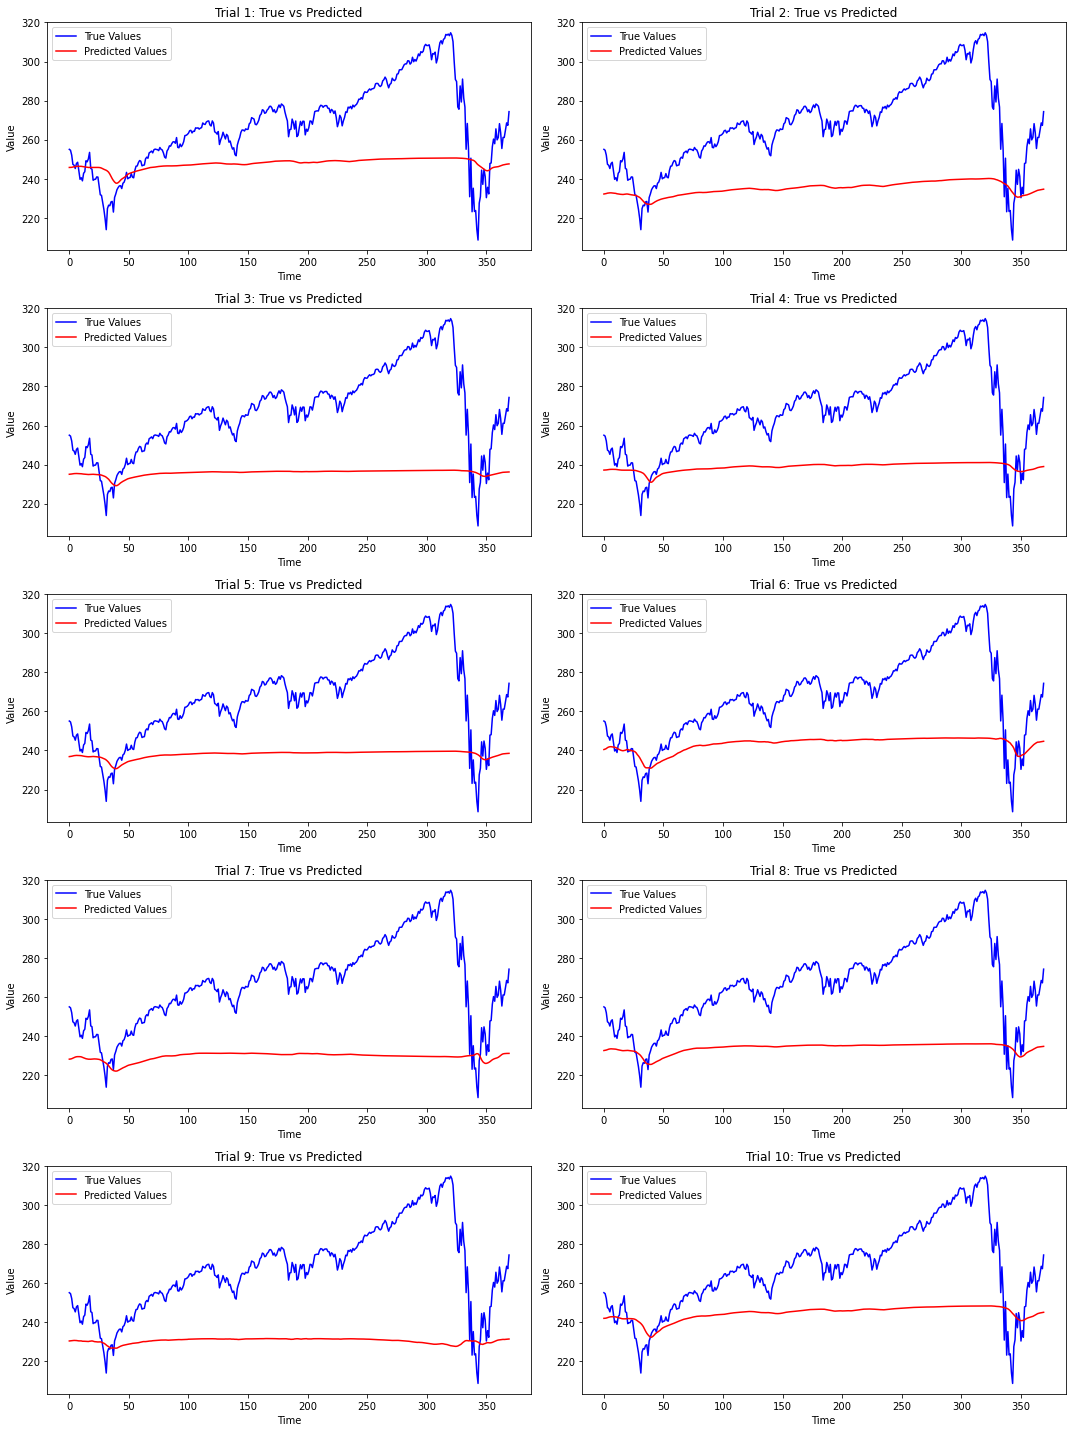


===== Final Results Across 10 Trials =====
Average Validation Loss: 155.6023 ± 75.8329
Average Test Loss: 1309.7773 ± 344.2127
Average MAE: 30.8841 ± 4.7965
Average Error Percentage: 11.05% ± 1.79%
Largest Error Percentage: 23.85% ± 2.25%


In [84]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# Create directory for saving models
save_dir = "./lstm_models_temp/"
os.makedirs(save_dir, exist_ok=True)

# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 128
num_layers = 2
dropout_rate = 0.1
learning_rate = 0.0005
num_epochs = 500
patience = 30
num_trials = 10

# Store results
results = {
    "val_loss": [],
    "test_loss": [],
    "mae": [],
    "avg_error_percent": [],
    "largest_error_percent": []
}

# Multi-plot setup
fig, axes = plt.subplots(5, 2, figsize=(15, 20))  # 5 rows, 2 columns

for trial in range(num_trials):
    print(f"\n===== Trial {trial+1} =====")
    
    # Initialize model
    model = ComplexLSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate).to(device)

    # Define loss and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop with early stopping
    best_val_loss = float('inf')
    early_stop_counter = 0
    best_model_path = os.path.join(save_dir, f"best_model_trial_{trial+1}.pth")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_batch = y_batch.unsqueeze(1)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping & model saving
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), best_model_path)  # Save best model
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    # Load the best model before evaluation
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    
    # Evaluate on test data
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)

    test_loss /= len(test_loader.dataset)

    # Calculate Mean Absolute Error (MAE)
    test_mae = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            mae = torch.mean(torch.abs(outputs - y_batch))
            test_mae += mae.item() * X_batch.size(0)

    test_mae /= len(test_loader.dataset)

    # Compute error percentages
    X_seq_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_seq_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
    outputs = model(X_seq_tensor).cpu().detach().numpy()

    error = 0
    largest_error = 0
    
    for true, pred in zip(y_test, outputs):
        percent = abs(true - pred) / true
        if percent > largest_error:
            largest_error = percent
        error += percent

    avg_error = (error / len(y_test)).item()
    largest_error = largest_error.item()

    # Store results
    results["val_loss"].append(best_val_loss)
    results["test_loss"].append(test_loss)
    results["mae"].append(test_mae)
    results["avg_error_percent"].append(avg_error * 100)
    results["largest_error_percent"].append(largest_error * 100)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Average error percentage: {avg_error * 100:.2f}%")
    print(f"Largest error percentage: {largest_error * 100:.2f}%")

    # Plot predictions
    ax = axes[trial // 2, trial % 2]
    ax.plot(y_test, label='True Values', color='blue')
    ax.plot(outputs, label='Predicted Values', color='red')
    ax.set_title(f'Trial {trial + 1}: True vs Predicted')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.legend()

# Display all subplots
plt.tight_layout()
plt.show()

# Print final average results
print("\n===== Final Results Across 10 Trials =====")
print(f"Average Validation Loss: {np.mean(results['val_loss']):.4f} ± {np.std(results['val_loss']):.4f}")
print(f"Average Test Loss: {np.mean(results['test_loss']):.4f} ± {np.std(results['test_loss']):.4f}")
print(f"Average MAE: {np.mean(results['mae']):.4f} ± {np.std(results['mae']):.4f}")
print(f"Average Error Percentage: {np.mean(results['avg_error_percent']):.2f}% ± {np.std(results['avg_error_percent']):.2f}%")
print(f"Largest Error Percentage: {np.mean(results['largest_error_percent']):.2f}% ± {np.std(results['largest_error_percent']):.2f}%")
